In [1]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
#import pyfluidsynth

from pathlib import Path
import pretty_midi
import librosa.display
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

%run midi_util.py

folder = 'train/'

# Preprocess Midi file
#### Choose a harmony and a melody track from a MIDI file

In [2]:
## PARAMS
# highest note is melody
low = 48 # C2=48, C3=60, C4=72, C5=84, C6=96
high = 84 # 36 notes 
pause = 36 # note 37 (index nr 36) in representation is pause
maxnotelength = 47

# input sizes
MELODY = 37 
TIMES = 48
CHORDS = 12
INPUTSHAPE = MELODY + TIMES + CHORDS*2
INPUTSHAPE

109

In [3]:
def getMelodyAndHarmonyInstruments(file):
    def padAndAdd(a,b):
        return sorted(a+b,key= lambda x:x.start)
    
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    fs = pm.resolution # ERROR PRONE
    print("\nProcessing: "+file)
    
    
    if len(pm.instruments) == 1:
        print("Both: Using only track for both harmony and melody")
        pianoroll = pm.instruments[0].notes
        return {'melody': pianoroll, 'harmony': pianoroll}
    
    if len(pm.instruments) <= 2:
        print("Both: Using track with most notes for harmony other for melody")
        pianoroll = pm.instruments[0].get_piano_roll(fs=fs).T
        pianoroll2 = pm.instruments[1].get_piano_roll(fs=fs).T
        if pianoroll.nonzero()[0].shape[0] > pianoroll2.nonzero()[0].shape[0]:
            return {'melody': pm.instruments[0].notes, 'harmony': pm.instruments[1].notes}
        else:
            return {'melody': pm.instruments[1].notes, 'harmony': pm.instruments[0].notes}
    
    else:
        maxlen = 0
        pianos = []
        guitars = []
        melodies = []
        for i, elt in enumerate(pm.instruments):
            if pm.instruments[i].is_drum:
                continue
            pianoroll = pm.instruments[i].get_piano_roll(fs=fs).T
            numnotes = pianoroll.nonzero()[0].shape[0]
            print(pm.instruments[i])
            if numnotes > maxlen:
                mostnotes = i
                maxlen = numnotes
            if 'piano' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(8): # MIDI 0..7 are pianos
                pianos.append((pm.instruments[i].notes,numnotes))
            if 'guitar' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(24,32):
                guitars.append((pm.instruments[i].notes,numnotes))
            if 'melody' in pm.instruments[i].name.lower():
                # melodies.append((pianoroll,numnotes)) do i really want to padandadd two melodies always??
                melodies.append(pm.instruments[i].notes)

        if pianos != []:
            print("Harmony: Using piano with most notes as harmony of", len(pianos))
            pianowithmostnotes = max(pianos, key=lambda x: x[1])
            harmonytrack = pianowithmostnotes[0]
        elif guitars != []:
            print("Harmony: Using guitar with most notes as harmony of", len(guitars))
            guitarwithmostnotes = max(guitars, key=lambda x: x[1])
            harmonytrack = guitarwithmostnotes[0]
        else:
            print("Error: no piano or guitar track found")
            harmonytrack = pm.instruments[0].notes

        if len(melodies) == 1:
            print("Melody: using only melody track as melody")
            melodytrack = melodies[0]
        elif len(melodies) == 2:
            print("Melody: padding and adding two melodies to one")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        elif len(melodies) > 2:
            print("Melody: more than 2 melody tracks. not handled")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        else:
            print("Error: no melody track found.")
            melodytrack = pm.instruments[0].notes

        return {'melody': melodytrack, 'harmony': harmonytrack}
    
def getMelodyAndHarmony(file):
    def padAndAdd(a,b):
        return sorted(a+b,key= lambda x:x.start)
    
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    print("\nEasy Processing: "+file)
    
    if len(pm.instruments) == 1:
        print("Both: Using only track for both harmony and melody")
        pianoroll = pm.instruments[0].notes
        return {'melody': pianoroll, 'harmony': pianoroll}
    
    else:
        maxlen = 0
        pianos = []
        guitars = []
        melodies = []
        for i, elt in enumerate(pm.instruments):
            if pm.instruments[i].is_drum:
                continue
            pianoroll = pm.instruments[i].get_piano_roll().T
            numnotes = pianoroll.nonzero()[0].shape[0]
            if numnotes > maxlen:
                mostnotes = i
                maxlen = numnotes
            if 'piano' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(8): # MIDI 0..7 are pianos
                pianos.append((pm.instruments[i].notes,numnotes))
            if 'guitar' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(24,32):
                guitars.append((pm.instruments[i].notes,numnotes))
            if 'melody' in pm.instruments[i].name.lower():
                # melodies.append((pianoroll,numnotes)) do i really want to padandadd two melodies always??
                melodies.append(pm.instruments[i].notes)

        if pianos != []:
            print("Harmony: Using piano with most notes as harmony of", len(pianos))
            pianowithmostnotes = max(pianos, key=lambda x: x[1])
            harmonytrack = pianowithmostnotes[0]
        elif guitars != []:
            print("Harmony: Using guitar with most notes as harmony of", len(guitars))
            guitarwithmostnotes = max(guitars, key=lambda x: x[1])
            harmonytrack = guitarwithmostnotes[0]
        else:
            print("Error: no piano or guitar track found")
            harmonytrack = pm.instruments[0].notes
            return

        if len(melodies) == 1:
            print("Melody: using only melody track as melody")
            melodytrack = melodies[0]
        elif len(melodies) == 2:
            print("Melody: padding and adding two melodies to one")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        elif len(melodies) > 2:
            print("Melody: more than 2 melody tracks. padding and adding first two of # ", len(melodies),"melodies.")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        else:
            print("Error: no melody track found.")
            melodytrack = pm.instruments[0].notes
            return

        return {'melody': melodytrack, 'harmony': harmonytrack}

In [54]:
def oneHot(idx, arraysize):
        if idx > arraysize:
            print("error idx > arraysize")
            return
        ar = np.zeros(arraysize)
        ar[idx] = 1
        return ar

def processMidi(file):
    pm = pretty_midi.PrettyMIDI(file)
    tracks = getMelodyAndHarmony(file)

    pmnotes = tracks['melody']
    notes, times = [], []
    currenttime = 0
    for i, note in enumerate(pmnotes):
        if note.start > currenttime:
            notes.append(pause)
            duration = pm.time_to_tick(note.start-currenttime)
            times.append(duration)
        if note.pitch in range(low,high):
            notes.append(note.pitch - low)
        else:
            notes.append(note.pitch % 12)
        if i < len(pmnotes)-1 and pmnotes[i+1].start < note.end:
            times.append(pm.time_to_tick(pmnotes[i+1].start-note.start))
        else:
            times.append(pm.time_to_tick(note.end-note.start))
        currenttime = note.end
    times = np.array(np.round(np.array(times)/pm.resolution*12),dtype=np.int32)
    
    #cleanup
    times[np.where(times > 48)[0]] = 48
    
    notes = np.array(notes)[np.where(times>0)[0]]
    times = times[np.where(times > 0)[0]]
    times = times - 1 # reshift to 0..47
    
    
    # getChords
    pmnotes = tracks['harmony']
    notesDict = {}
    for i, note in enumerate(pmnotes):
        startbeat = int(pm.time_to_tick(note.start)/pm.resolution)
        endbeat = int(pm.time_to_tick(note.end)/pm.resolution)
        for j in range(startbeat, endbeat): #evry beat
            notesDict[j] = notesDict.get(j,np.zeros(12)) + oneHot(note.pitch % 12,12)

    # append for every beat (timestep) a vector. either np.zeros or chordinfovector
    chords = []
    for i in range(max(notesDict)): 
        chords.append(notesDict.get(i,np.zeros(12)))
    chords = np.array(chords)

    # connect notes and chords
    currbeat = 0
    newchords = []
    for time in times:
        beat = int(currbeat/12)
        newchord = np.zeros(12)
        for j in range(int((time)/12)+1): 
            newchord += chords[j+beat]
        newchords.append(newchord)
        currbeat += time
    chords = np.array(newchords)
    
    return notes, times, chords

def getCircleOfThirds(note):
    """input: note, scalar in [0,C)
    output: array, size (11,) including 3 bits for octave, 1 for rest
    """
    circleMajor = lambda x: x%4
    circleMinor = lambda x: x%3
    representation = np.zeros(11)
    if note < pause:
        absnote = note % 12
        octave = int(note/12)
        representation[7+octave] = 1
        representation[circleMajor(absnote)] = 1
        representation[4+circleMinor(absnote)] = 1
    else:
        representation[-1] = 1
    return representation

def getDuration(duration):
    """input size (1,) in [0,48)
       output size (6,)
    """
    return np.unpackbits(np.uint8(duration))[2:]

def getChord(chord):
    """input size (12,)
    outputs current and next chord shape (7,)
    """
    repre = np.zeros(7)
    for i, elt in enumerate(chord):
        x = elt * getCircleOfThirds(i)[:7]
        repre += x
    return repre

def getFeatureVectors(notes, times, chords, encodingDict, modulation=False): #TODO modulation ueberdenken
    """input size [7(pitch)+2(octaves)+1(Rest)]+6(duration)+7(chords)+7(nextchords)=30=Fsize #TODO: maybe change chords
    Creates Feature Vector from notes lists.
    Input: notes, times, chords from processMIDI
    Output: features array, size: (N, Fsize)  Fsize varies
    """
    features = []
    for i, note in enumerate(notes[:-1]):
        feature = np.empty(0)
        if encodingDict['melody']:
            elt = np.zeros(37)
            if notes[i] == pause:
                elt[notes[i]] = 1
            elif notes[i] < pause:
                elt[notes[i]] = 1 # melody bit
            else:
                print("melody over 37")
            feature = np.concatenate((feature,elt))
        if encodingDict['melodyEncoded']: # pitch+octave+rest
            feature = np.concatenate((feature,getCircleOfThirds(note)))
        if encodingDict['duration']:
            elt = np.zeros(48)
            elt[int(times[i])] = 1
            feature = np.concatenate((feature,elt))  
        if encodingDict['durationEncoded']:
            feature = np.concatenate((feature,getDuration(times[i])))
        if encodingDict['chordsNormally']:
            feature = np.concatenate((feature,chords[i]))
            feature = np.concatenate((feature,chords[i+1]))
        if encodingDict['chordsEncoded']:
            feature = np.concatenate((feature,getChord(chords[i])))  # chord ERROR: MAKE THIS BETTER
            feature = np.concatenate((feature,getChord(chords[i+1])))   # chord ERROR: MAKE THIS BETTER
        features.append(feature)
    features = np.array(features)
    return features

def getInputSequences(notes, times, chords, encodingDict, modulation=False, padding=False, seq_len=16):
    """Create Net Input.
    Input: features from getFeatureVectors or getEncodedFeatureVectors
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,) # TODO: add times to label
    """
    features = getFeatureVectors(notes, times, chords, encodingDict, modulation)
    sequences = []
    labels = []
    i = 0
    if padding == True:
        padded_notes = np.concatenate((np.zeros((seq_len,features.shape[1])),features[:seq_len]))
        for j in range(seq_len):
            sequences.append(padded_notes[j:j+seq_len])
            label_pitch = notes[j]
            label_duration = times[j]
            labels.append((label_pitch, label_duration))
    while i+seq_len < features.shape[0]:
        sequences.append(features[i:i+seq_len])
        label_pitch = notes[i+seq_len]
        label_duration = times[i+seq_len]
        labels.append((label_pitch, label_duration))
        i += 1     # or += seq_len
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels


def getInputSequencesAABA(notes, times, chords, encoding=True, modulation=False, padding=False, seq_len=1):
    """Create Net Input.
    Input: features from getFeatureVectors or getEncodedFeatureVectors
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,) # TODO: add times to label
    """
    if encoding:
        features = getEncodedFeatureVectors(notes, times, chords, modulation)
    else:
        features = getFeatureVectors(notes, times, chords, modulation)
    sequences = []
    labels = []
    i = 0
    while i+seq_len < features.shape[0]:
        sequences.append([features[0]])
        label_pitch = notes[i+seq_len]
        label_duration = times[i+seq_len]
        labels.append((label_pitch, label_duration))
        i += 1     # or += seq_len
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels


Choose encoding and load files

In [8]:
encodingDict = {
    'melody': True,
    'melodyEncoded': True,
    'duration': False,
    'durationEncoded': True,
    'chordsNormally': True,
    'chordsEncoded': True
}

In [9]:
files = os.listdir("train")
files.remove('.DS_Store')

for i, file in enumerate(files):
    notes, times, chords = processMidi(folder+file)
    sequences, labels = getInputSequences(notes, times, chords, encodingDict, modulation=False, padding=False, seq_len=16)
    X = sequences if i==0 else np.concatenate((X, sequences))
    y = labels if i==0 else np.concatenate((y, labels))
    
X.shape, y.shape


Easy Processing: train/trainprep.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody

Easy Processing: train/girlfromipanemaprep.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody

Easy Processing: train/browneyedgirlprep.mid
Harmony: Using guitar with most notes as harmony of 1
Melody: using only melody track as melody

Easy Processing: train/swayprep.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody

Easy Processing: train/amazinggraceprep.mid
Harmony: Using guitar with most notes as harmony of 1
Melody: padding and adding two melodies to one

Easy Processing: train/myfunnyvalentineprep.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody

Easy Processing: train/newyorkprep.mid
Harmony: Using guitar with most notes as harmony of 1
Melody: more than 2 melody tracks. padding and adding first two of

((3729, 16, 92), (3729, 2))

In [10]:
# train/val split
n = 3000
n = min(n,X.shape[0])
data = X[:n]
labels = y[:n]

perm = np.random.permutation(n)
p = int(0.8*n)

train_data = data[perm[:p]]
train_labels = labels[perm[:p]]
val_data = data[perm[p:]]
val_labels = labels[perm[p:]]

train_data.shape, train_labels.shape

((2400, 16, 92), (2400, 2))

## Load Data for Pytorch

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, transform=None):
        super(Dataset, self).__init__()
        self.inputs = inputs
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        label = self.labels[idx]
        if self.transform: 
            inputs = self.transform(inputs)
        return inputs, label
    
def getDataLoader(data, labels, batch_size=32, shuffle=True, sample=False):
    dataset = Dataset(data, labels)   

    if sample:
        counter = collections.Counter(train_labels[:,0])
        #display(counter)
        for elt in counter:
            counter[elt] = 1. / counter[elt]
        weights  = []
        for i in range(MELODY): # error prone
            weights.append(counter.get(i,0))
        weights = torch.Tensor(weights)
        train_weights=weights[train_labels[:,0]]
        sampler = torch.utils.data.WeightedRandomSampler(weights=train_weights,num_samples=len(train_weights),replacement=True)
        train_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size, shuffle=False)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    return train_loader


## Model

In [12]:
#####################
# Build model
#####################

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_pitch, output_dim_duration, num_layers=1, dropout=0.5):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim_pitch = output_dim_pitch
        self.output_dim_duration = output_dim_duration
        self.num_layers = num_layers
        self.hidden = self.init_hidden(batch_size)

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.bn2 = nn.BatchNorm1d(self.hidden_dim)
        
        self.linear_pitch = nn.Linear(self.hidden_dim, self.output_dim_pitch)
        self.linear_duration = nn.Linear(self.hidden_dim, self.output_dim_duration)
        
        
        print("Nr. of params:", self.get_nr_params())
    
    def get_nr_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        # Only take the output from the final timetep
        fc_input = lstm_out[:,-1,:]
        #fc_input = self.bn2(lstm_out[:,-1,:])
        
        pitch = self.linear_pitch(fc_input)
        duration = self.linear_duration(fc_input)
        # log_probs = F.log_softmax(y_pred,dim=1) # crossentropy is already with softmax
        return pitch, duration

def train(model, train_loader, val_loader, optim, loss_fn, num_epochs=100):

    hist = np.zeros(num_epochs)

    def clip_gradient(model, clip_value):
        params = list(filter(lambda p: p.grad is not None, model.parameters()))
        for p in params:
            p.grad.data.clamp_(-clip_value, clip_value)

    for t in range(num_epochs):
        loss_curr = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            batch_size = inputs.size(0)
            model.hidden = model.init_hidden(batch_size)

            optim.zero_grad()
            pitch, duration = model(inputs.float())
            #print(pitch.shape)

            loss_pitch = loss_fn(pitch, labels[:,0].long())
            loss_duration = loss_fn(duration, labels[:,1].long())

            loss = loss_pitch + loss_duration

            loss.backward(retain_graph=True)
            #clip_gradient(model, 1e-1)
            optim.step()

            loss_curr = loss_curr + loss.item()

        hist[t] = loss_curr
        if t%10==0:
            notes = t%50==0
            acc_train, dacc_train = evaluation(model, train_loader, notes)
            acc_val, dacc_val = evaluation(model, val_loader, notes=False)
            print("loss: ", np.round(hist[t], 4), "acc_train: ", np.round(acc_train,2), "acc_val: ", np.round(acc_val,2))
            print("loss: ", np.round(hist[t], 4), "dacc_train: ", np.round(dacc_train,2), "dacc_val: ", np.round(dacc_val,2))

    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
    

def evaluation(model, loader, notes=False):
    model.eval()
    correct, total, dcorrect, dtotal = 0,0,0,0 
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        pitch, duration = model(inputs.float())
        
        _, predicted = torch.max(pitch.data, 1)
        total += labels[:,0].size(0) 
        correct += (predicted == labels[:,0].long()).sum().item()
        
        _, dpredicted = torch.max(duration.data, 1)
        dtotal += labels[:,1].size(0) 
        dcorrect += (dpredicted == labels[:,1].long()).sum().item()
        
        if notes and i == 0:
            print(predicted)
            print(labels[:,0])
    
    acc = int(100 * correct / total)
    dacc = int(100 * dcorrect / dtotal)
    model.train()
    return acc, dacc

# Training

#### we need 3 things: Data(loader), Model, Optimization(Training)

In [13]:
# Data(loader)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size, sample=True)
val_loader = getDataLoader(train_data, train_labels, batch_size, shuffle=False)

# Model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 2,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES
}

model = LSTM(**model_params)

Nr. of params: 79381


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


tensor([30, 12,  4, 12, 11, 11, 12, 30, 31, 30, 30, 11, 12, 11, 12, 14, 30, 16,
        12, 11, 30, 30, 12, 30, 31, 30, 11, 11, 11, 30, 31, 14])
tensor([21, 18, 14, 12,  7,  4, 17, 30, 26, 20, 20,  2, 17,  9, 19, 14, 27, 14,
        14, 11, 31, 13, 15, 14, 24, 21, 12, 24, 15, 30, 15, 26])
loss:  473.2584 acc_train:  13 acc_val:  7
loss:  473.2584 dacc_train:  29 dacc_val:  38
loss:  218.2693 acc_train:  52 acc_val:  17
loss:  218.2693 dacc_train:  59 dacc_val:  45
loss:  161.715 acc_train:  62 acc_val:  18
loss:  161.715 dacc_train:  73 dacc_val:  49
loss:  143.8581 acc_train:  65 acc_val:  25
loss:  143.8581 dacc_train:  77 dacc_val:  51
loss:  125.507 acc_train:  69 acc_val:  27
loss:  125.507 dacc_train:  80 dacc_val:  55
tensor([27, 27, 13, 29, 20, 23, 26, 12,  7, 18, 18, 27, 24, 18, 11, 27,  9,  9,
        25, 18,  9, 12, 12, 25, 11, 20,  9, 27, 25, 18, 19, 30])
tensor([27, 27, 13, 29, 20, 24, 26, 22,  7, 18, 12, 27, 24, 15, 11, 27,  9,  9,
        25, 18,  9, 12, 22, 25, 11, 20, 

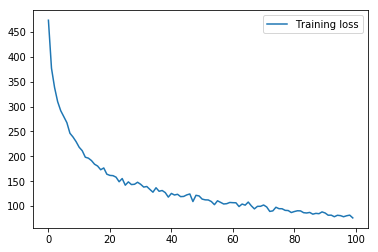

In [14]:
# Training(Optimizer)
train_params = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'optim': torch.optim.Adam(model.parameters(), lr=1e-3),
    #optim: torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 100
}

train(model, **train_params)

# Test Framework

In [717]:
# read test midi file ignore labels
# output from network
# create midi file with input midi and prediction from network
# simply read midi here to see how it sounds + plot

def getOneHot(arr, maxValue=pause):
    """#TODO: Note length is fixed on 8
    Input: arr, shape (N,) with values in (0,C) 
    Output: ar, shape (N,24) with one-hot values
    """
    ar = np.zeros((arr.shape[0]*8, maxValue))
    c = 0
    for i in range(arr.shape[0]):
        note = int(arr[i])
        if note < maxValue:
            ar[c:c+8, note] = 1
        c += 8
    return ar

def getPianoRoll(pitches, durations, maxValue = MELODY-1):
    """#TODO: Note length is fixed on 8
    Input: 
        - pitches, shape (N,) with values in [0,MELODY) 
        - durations, shape (N,) with values in [0,TIMES)
    
    Output: ar, shape (N,24) with one-hot values
    """
    ar = np.zeros((int(durations.shape[0]*durations.sum()), maxValue))
    c = 0
    for i in range(pitches.shape[0]):
        note = int(pitches[i])
        duration = int(durations[i])
        if note < maxValue:
            ar[c:c+duration, note] = 1
        c += duration
    return ar

def getPredictedNotes(notes, times, chords):
    test_data, test_labels = getInputSequences(notes,times,chords,encodingDict)
    
    test_loader = getDataLoader(test_data,test_labels, batch_size=32, shuffle=False)
    
    predicted_notes = np.empty(0)
    predicted_durations = np.empty(0)
    model.eval()
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        pitch, duration = model(inputs.float())

        _, pred_pitch = torch.max(pitch.data, 1)
        _, pred_duration = torch.max(duration.data, 1)
        predicted_notes = np.concatenate((predicted_notes,pred_pitch.detach().numpy()))
        predicted_durations = np.concatenate((predicted_durations, pred_duration.detach().numpy()))
    return predicted_notes, predicted_durations

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def getPlotAndSound(pianoroll, savename):
    createMidiFromPianoRoll(pianoroll, low, 'treval', savename, tempo=200, threshold=0.1, resolution=8)
    pm = pretty_midi.PrettyMIDI('treval/'+savename+'.mid')
    plt.figure(figsize=(8, 4))
    plot_piano_roll(pm, 48, 84)
    display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))

def plotPianoRoll(file, netout='netout', realout='realout'):
    notes, times, chords = processMidi(file)
    
    _, labels = getInputSequences(notes,times,chords,encodingDict)
    pianoroll = getPianoRoll(labels[:,0],labels[:,1])

    pitches, durations = getPredictedNotes(notes, times, chords)
    pianoroll2 = getPianoRoll(pitches, durations)
        
    print("durations", durations)
    getPlotAndSound(pianoroll, netout)
    getPlotAndSound(pianoroll2, realout)


Easy Processing: test/testautumnleaves.mid
Harmony: Using piano with most notes as harmony of 1
Melody: padding and adding two melodies to one
durations [ 3. 12.  3.  4.  4. 12.  3.  3. 19.  6.  4.  8. 20.  6.  7.  8. 20.  2.
  2. 20.  4.  0.  4. 47.]


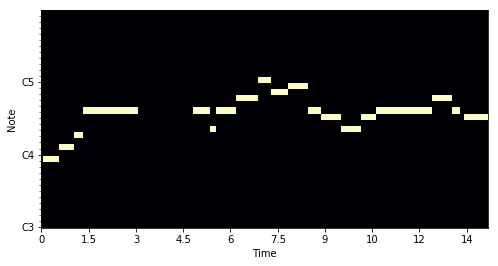

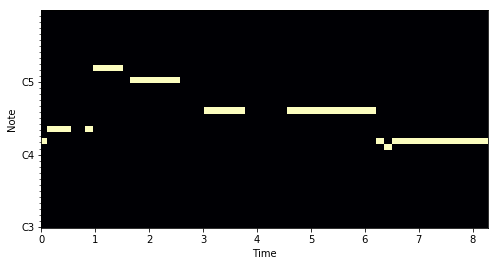

In [719]:
file = 'test/testautumnleaves.mid'
plotPianoRoll(file, 'netout', 'realout')

In [106]:
notes = [0,2,4,7,7,4,2,0,0,2,4,7,7,4,2,0,0,5,3,4,5,8,7,5,0,2,4,7,7,4,2,0]
times = [12]*32
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
train_data, train_labels = getInputSequences(notes, times, chords, encodingDict=encodingDict, modulation=False, padding=False, seq_len=1)


# new TestFramework
predicted_notes, predicted_durations = [], []


mel_len=16+1 # wegen nextChord

notes = notes[-mel_len:]
times = times[-mel_len:]
chords = chords[-mel_len:]

for i in range(mel_len):
    feat = getFeatureVectors(notes, times, chords, encodingDict)
    feat = torch.Tensor(feat).unsqueeze(0)

    model.hidden = model.init_hidden(feat.size(0))
    pitch, duration = model(feat.float())

    pred_pitch = torch.max(pitch.data, 1)[1].detach().numpy()[0]
    pred_duration = torch.max(duration.data, 1)[1].detach().numpy()[0]

    predicted_notes.append(pred_pitch)
    predicted_durations.append(pred_duration)
    notes = notes[1:]
    notes.append(pred_pitch)
    times = times[1:]
    times.append(pred_duration)
    chords = chords # TODO
    print(pred_pitch, notes)


12 [0, 5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12]
21 [5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21]
36 [3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36]
36 [4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36]
36 [5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36]
21 [8, 7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21]
24 [7, 5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24]
12 [5, 0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12]
21 [0, 2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21]
10 [2, 4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10]
19 [4, 7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19]
36 [7, 7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19, 36]
19 [7, 4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19, 36, 19]
19 [4, 2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19, 36, 19, 19]
12 [2, 0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19, 36, 19, 19, 12]
22 [0, 12, 21, 36, 36, 36, 21, 24, 12, 21, 10, 19, 36, 

## Test A

In [43]:
# test how much % model can learn a melody

# define test melody
# train network
# give percentage of how much it learnt

chordsDict={
    'C': [1,0,0,0,1,0,0,1,0,0,0,0],
    'C7': [1,0,0,0,1,0,0,1,0,0,1,0],
    'Cmaj7': [1,0,0,0,1,0,0,1,0,0,0,1]
}

In [118]:
# test data
notes = [0,2,4,7,7,4,2,0,0,2,4,7,7,4,2,0,0,5,3,4,5,8,7,5,0,2,4,7,7,4,2,0]
times = np.ones(32)*8
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)


(15, 16, 31)

Nr. of params: 30485


tensor([2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  7.3719 acc_train:  6 acc_val:  6
loss:  1.8806 acc_train:  20 acc_val:  20
loss:  1.8009 acc_train:  26 acc_val:  26
loss:  1.6949 acc_train:  33 acc_val:  33
loss:  1.5203 acc_train:  53 acc_val:  53
tensor([0, 5, 8, 4, 5, 8, 7, 5, 0, 7, 4, 7, 5, 4, 7])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  1.2851 acc_train:  73 acc_val:  73
loss:  1.0255 acc_train:  80 acc_val:  80
loss:  0.8072 acc_train:  86 acc_val:  86
loss:  0.6302 acc_train:  86 acc_val:  86
loss:  0.4656 acc_train:  93 acc_val:  93
tensor([0, 5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  0.3227 acc_train:  100 acc_val:  100
loss:  0.2176 acc_train:  100 acc_val:  100
loss:  0.1449 acc_train:  100 acc_val:  1

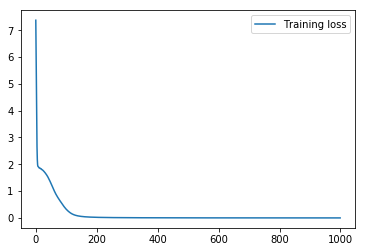

In [119]:
train_params = {
    'train_loader': train_loader,
    'val_loader': train_loader,
    'optim': torch.optim.Adam(testmodel.parameters(), lr=1e-2),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 1000
}
train(testmodel, **train_params)

# Test B

In [ ]:
notes = np.ones(32)*8
times = [8]
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)


# Examples and Visuals

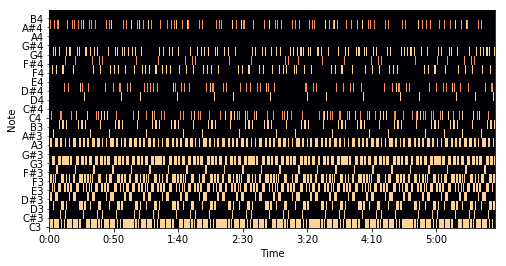

In [10]:
fs = 8
pm = pretty_midi.PrettyMIDI("train/train.mid")
piano_midi = pm.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll(fs=fs)
piano_roll = piano_roll[48:72].T

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 48, 72)

In [7]:
files_dir = "train/"
files_dir = glob.glob("%s*.mid" %(files_dir))
resolution = 8 #ticks per beat

low, high, ticks = getNoteRangeAndTicks(files_dir)
tr = fromMidiCreatePianoRoll(files_dir, ticks, low, high)
#createMidiFromPianoRoll(tr[0], low, "treval/", 'test', tempo=200)

In [8]:
# smallest LSTM example
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True) # It was batch_first=True!
inputs = torch.randn(5, 300, 10)
hidden = (torch.randn(2, 5, 20), torch.randn(2, 5, 20))
output, hidden = rnn(inputs, hidden)
output.shape

torch.Size([5, 300, 20])

# Train Val Split

In [9]:
def standardize(data):
    """ Move {0,1} data to {-1,1}, then standardize. Standardize data in [0,1]"""
    data = data.astype(np.float32)
    standardized_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
    return standardized_data

In [11]:
a = standardize(train_data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [22]:
np.std(train_data, axis=0)

array([[0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
train_data[0]

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])